# Demo data calculations
This demonstrates the use of low-level routines to replicate signal analysis performed by SEA.

Each analysis product is returned as a `xarray.DataArray`. At the end, they are merged into a single `xarray.Dataset` containing all all the different data results along with their labels, coordinates, and metadata.

### Generate fake data

In [1]:
import matplotlib
import iqwaveform.figures
import numpy as np
import channel_analysis

iq = np.load('lookout-mountain-3705MHz-15.36MSps.npy')
fs = 15.36e6
iq = iq[:round(0.1*15.36e6)]
capture = channel_analysis.FilteredCapture(sample_rate=fs, analysis_bandwidth=10e6, duration=iq.size/fs)

### Channel power time-series

In [2]:
pvt = channel_analysis.channel_power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    power_detectors=('rms', 'peak'),
).to_xarray()

In [3]:
%%timeit -n1 -r1

channel_analysis.channel_power_time_series(
    iq,
    capture,
    detector_period=10e-3,
    power_detectors=('rms', 'peak'),
).to_xarray()

23.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


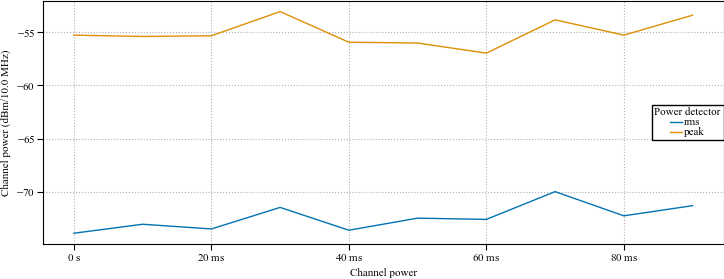

In [4]:
from iqwaveform import powtodB
from matplotlib import pyplot as plt
from channel_analysis import figures

plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()

pvt.plot.line(x='time_elapsed', ax=ax)

figures.label_axis(ax.xaxis, pvt, 'time_elapsed')
figures.label_axis(ax.yaxis, pvt, tick_units=False)
figures.label_legend(ax, pvt, 'power_detector')

### Cyclic channel power

In [5]:
cyclic_power = channel_analysis.cyclic_channel_power(
    iq,
    capture,
    cyclic_period=10e-3,
    detector_period=1e-3 / 15 / 4,
    power_detectors=('rms', 'peak'),
    cyclic_statistics=('min', 'mean', 'max'),
).to_xarray()

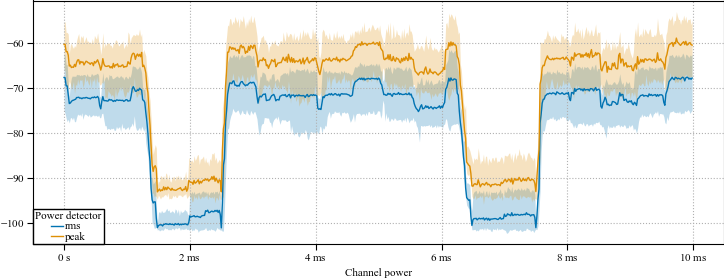

In [6]:
fig, ax = plt.subplots()

time = cyclic_power.cyclic_lag

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.plot(time, (a.sel(cyclic_statistic='mean')), color=f'C{i}')

for i, detector in enumerate(cyclic_power.power_detector.values):
    a = cyclic_power.sel(power_detector=detector)

    ax.fill_between(
        time,
        (a.sel(cyclic_statistic='min')),
        (a.sel(cyclic_statistic='max')),
        color=f'C{i}',
        alpha=0.25,
        lw=0,
        rasterized=True,
    )

figures.label_axis(ax.xaxis, cyclic_power, 'cyclic_lag')
figures.label_axis(ax.yaxis, cyclic_power, tick_units=False)
figures.label_legend(ax, cyclic_power, 'power_detector')

### Cellular cyclic autocorrelation

In [7]:
cyclic_autocorrelation = channel_analysis.cellular_cyclic_autocorrelation(
    iq,
    capture,
    subcarrier_spacings=(15e3, 30e3, 60e3),
).to_xarray()

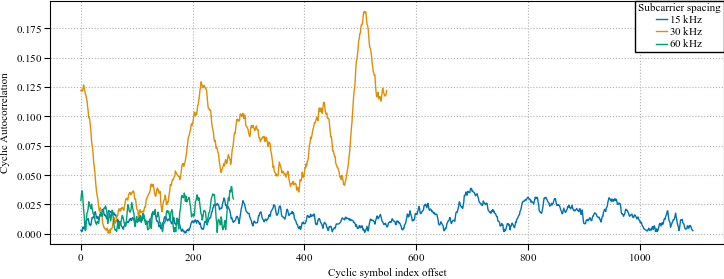

In [8]:
fig, ax = plt.subplots()

(cyclic_autocorrelation).plot.line(x='cyclic_sample_lag', ax=ax)
figures.label_legend(ax, cyclic_autocorrelation, 'subcarrier_spacing')

### Persistence Spectrum

In [9]:
frequency_resolution = 30e3
spectrum_quantiles = [0.5, 0.75, 0.95, 0.99, 1]

spectrum = channel_analysis.persistence_spectrum(
    iq,
    capture,
    window=('dpss', 3.87638403),
    frequency_resolution=frequency_resolution,
    persistence_statistics=spectrum_quantiles,
).to_xarray()

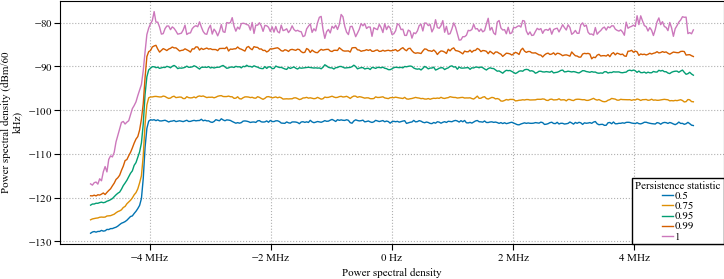

In [10]:
fig, ax = plt.subplots()

spectrum.plot.line(x='baseband_frequency', ax=ax)
figures.label_axis(ax.xaxis, spectrum, 'baseband_frequency')
# figures.label_legend(ax, spectrum, 'persistence_statistic')

### Spectrogram Power Distribution

In [11]:
spectrogram_ccdf = channel_analysis.spectrogram_ccdf(
    iq,
    capture,
    window=('dpss', 3.87638403),
    power_low=-170,
    power_high=0,
    power_resolution=0.25,
    frequency_resolution=15e3,
    fractional_overlap=0.,
    frequency_bin_size=12
).to_xarray()

TypeError: got an unexpected keyword argument 'frequency_bin_size'

In [13]:
# from channel_analysis.factories._spectrogram_ccdf import _debug
# import iqwaveform.figures

# spg = _debug['spg']
# timestep = (iq.size/capture.sample_rate)/iqwaveform.powtodB(spg).shape[0]

# c = plt.pcolormesh(iqwaveform.powtodB(spg[:round(20e-3/timestep)]), rasterized=True)
# plt.colorbar(c);

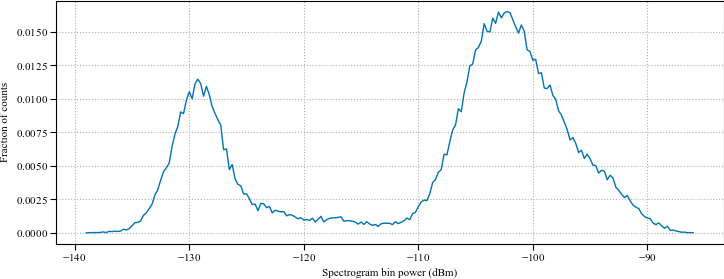

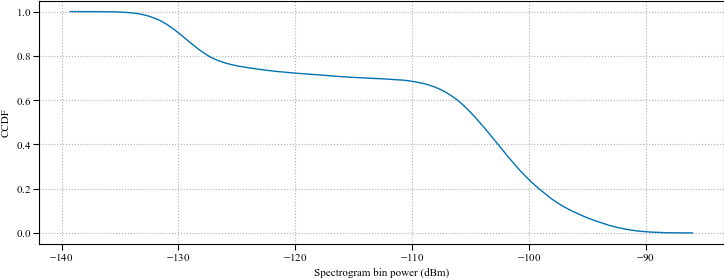

In [14]:
fig, ax = plt.subplots()

hist = -spectrogram_ccdf[(spectrogram_ccdf.values < 1)&(spectrogram_ccdf.values > 0)].diff('spectrogram_power_bin')
hist /= hist.sum()
hist.plot(ax=ax)
ax.set_ylabel('Fraction of counts')

fig, ax = plt.subplots()
spectrogram_ccdf[(spectrogram_ccdf.values < 1)&(spectrogram_ccdf.values > 0)].plot();

### Power sample CCDF

In [15]:
power_bins = dict(power_low=-130.0, power_high=-30.0, power_resolution=0.25)
channel_power_ccdf = channel_analysis.channel_power_ccdf(iq, capture, **power_bins).to_xarray()

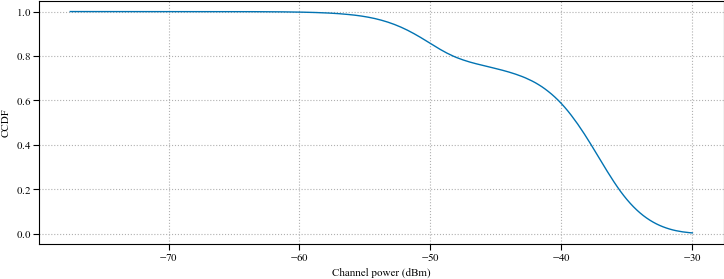

In [16]:
fig, ax = plt.subplots()
channel_power_ccdf[channel_power_ccdf.values < 1].plot(ax=ax)

### Putting it all together

In [17]:
# %%timeit -n1 -r1

# del iq

# iq = channel_analysis.simulated_awgn(capture, xp=np)
# iq = channel_analysis.filter_iq_capture(iq, capture)

analysis_spec = {
    'channel_power_time_series': {'detector_period': 10e-3, 'power_detectors': ('rms', 'peak')},
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'power_detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        # 'window': 'flattop',
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
        'frequency_resolution':1e3,
        'persistence_statistics': [0.5, 0.75, 0.95, 0.99, 1],
        'truncate': False,
    },
    'channel_power_ccdf': {
        'power_low': -40,
        'power_high': 15,
        'power_resolution': 221,  # 0.25 dB resolution
    },
    'cellular_cyclic_autocorrelation': {
        'subcarrier_spacings': [15e3, 30e3, 60e3]
    }
}

filter_spec = {
    'nfft': 1024,
    'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
}

result =  channel_analysis.analyze_by_spec(iq, capture, spec=analysis_spec)
result

<xarray.Dataset> Size: 465kB
Dimensions:                          (subcarrier_spacing: 3,
                                      cyclic_sample_lag: 1096,
                                      channel_power_bin: 1, power_detector: 2,
                                      time_elapsed: 10, cyclic_statistic: 3,
                                      cyclic_lag: 600,
                                      persistence_statistic: 5,
                                      baseband_frequency: 15360)
Coordinates:
  * subcarrier_spacing               (subcarrier_spacing) float32 12B 1.5e+04...
  * cyclic_sample_lag                (cyclic_sample_lag) float32 4kB 0.0 ... ...
  * channel_power_bin                (channel_power_bin) float32 4B -40.0
  * power_detector                   (power_detector) object 16B 'rms' 'peak'
  * time_elapsed                     (time_elapsed) float32 40B 0.0 ... 0.09
  * cyclic_statistic                 (cyclic_statistic) object 24B 'min' ... ...
  * cyclic_lag                       (cyclic_lag) float32 2kB 0.0 ... 0.009983
  * persistence_statistic            (persistence_statistic) object 40B 0.5 ....
  * baseband_frequency               (baseband_frequency) float64 123kB -7.68...
Data variables:
    cellular_cyclic_autocorrelation  (subcarrier_spacing, cyclic_sample_lag) float32 13kB ...
    channel_power_ccdf               (channel_power_bin) float32 4B 0.5856
    channel_power_time_series        (power_detector, time_elapsed) float32 80B ...
    cyclic_channel_power             (power_detector, cyclic_statistic, cyclic_lag) float32 14kB ...
    persistence_spectrum             (persistence_statistic, baseband_frequency) float32 307kB ...
Attributes:
    analysis_filter:     {'nfft': 8192, 'window': 'hamming'}
    duration:            0.1
    sample_rate:         15360000.0
    analysis_bandwidth:  10000000.0

In [18]:
%%timeit -n1 -r1

channel_analysis.analyze_by_spec(
    iq,
    capture,
    spec=analysis_spec,
)

628 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [19]:
%timeit -n1 -r1 channel_analysis.dump('test.zarr.zip', result, mode='w')

218 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
